In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pyjet

from matching import matching

plt.style.use("scientific.mplstyle")
file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

In [2]:
max_idx = 20000

recojet_pts = event_tree['Jet_pt'].array(entry_stop=max_idx, library='np')
recojet_etas = event_tree['Jet_eta'].array(entry_stop=max_idx, library='np')
recojet_phis = event_tree['Jet_phi'].array(entry_stop=max_idx, library='np')

genjet_pts = event_tree['GenJet_pt'].array(entry_stop=max_idx, library='np')
genjet_etas = event_tree['GenJet_eta'].array(entry_stop=max_idx, library='np')
genjet_phis = event_tree['GenJet_phi'].array(entry_stop=max_idx, library='np')

true_matching = event_tree['Jet_genJetIdx'].array(entry_stop=max_idx, library='np') # elements are arrys whoes i-th element matches the i-th recojet to the correct genjet. -1 when recojet is fake.

## Accuracy of matching algorithm
compare my matchings between recojet and genjet with the true matching

In [3]:
my_matchings = np.ndarray(max_idx, dtype='object')
n_matches = 0 # total number of made matches 

for i in range(max_idx):    
    my_matchings[i] = matching(recojet_etas[i], recojet_phis[i], genjet_etas[i], genjet_phis[i])
    n_matches += len(recojet_etas[i])

In [9]:
def matching_accuracy(my_matching, true_matching):
    '''
    Run matching algorithm for reco and gen jets. Using true_matching, the percentage of correct matches is deduced.
    '''
    # treat special case of an event with no jets:
    if len(true_matching) == 0:
        return 1.0, 1.0, 0
        
    # note that len(true_matching) == len(recojet_) always
    correct_match = np.where(my_matching==true_matching)[0]  
    n_correct = len(correct_match)
    n_fail = len(true_matching) - n_correct
    matching_acc = n_correct/len(true_matching)
    
        
    return matching_acc, n_correct, n_fail

In [10]:
accs = np.zeros(max_idx, dtype="float32")
n_correct, n_not_correct = 0, 0

for i in range(max_idx):
    accs[i], n_good, n_bad = matching_accuracy(my_matchings[i], true_matching[i])
    n_correct += n_good
    n_not_correct += n_bad

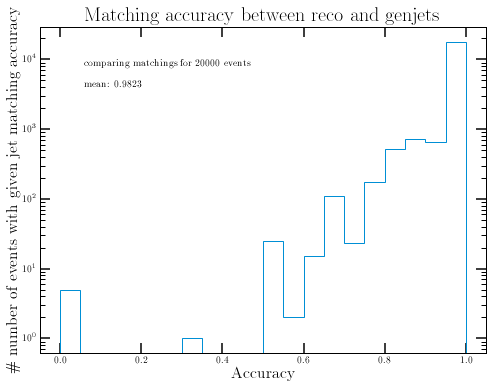

frequency of correct matching: 98.11%


In [19]:
fig = plt.figure(figsize=(8,6))
plt.hist(accs, bins=20, histtype='step')
plt.yscale('log')
plt.title("Matching accuracy between reco and genjets")
plt.xlabel("Accuracy")
plt.ylabel("\# number of events with given jet matching accuracy")
stats_str = "comparing matchings for {} events\n\nmean: {:.4f}".format(max_idx, np.mean(accs))
plt.text(0.1, 0.9, stats_str, ha='left', va='top', transform = plt.gca().transAxes)
plt.show()

print("frequency of correct matching: {:.2%}".format(n_correct/(n_correct+n_not_correct)))

#fig.savefig('plots/matching algo analysis/matching_acc.pdf')

#### Conclusion
The matching algorithm works well and one can expect that 96% of the made matches are accurate.

## Investigate mistakes of matching algorithm
The algorithm can make three mistakes:
1. match a fake jet, i.e. when element in my_matching is != -1 but true_matching = -1
2. not making a match i.e. labeling as fake jet eventhough is true jet: my_matching = -1 but true_matching != -1. Henceforth refered to as false fake jets.
3. make an incorrect match, i.e. element in my_matching = 3 but true_matching = 2. 

Note that the given frequency is always $\frac{\text{# error occurences}}{\text{total # matches}}$

Not that the matching is based on $\Delta R$ while the pt value of jets is not considered, other than matching hard jets first. Hence, I dont expect the pt distribution of the error jets to be of interest. 

In [ ]:
def matching_errors(my_matchings):
    '''Finds event and jet id where matching alogrithm has failed.
    Lists will be returned containing tuples (event_idx, jet_idx) where error occured. Note that jet_idx is index for reco jet.'''
    fake_jets = []
    falsefake = []
    wrong_match = []
    
    for i in range(max_idx):
        my_matching = my_matchings[i]
        
        if (my_matching == true_matching[i]).all():
            continue
        
        # Correct pair of j-th recojet is true_genidx
        for j,true_genidx in enumerate(true_matching[i]):
            # error 1
            if (true_genidx == -1) and (my_matching[j] != -1):
                fake_jets.append((i, j))
                continue
            # error 2
            elif (true_genidx != -1) and (my_matching[j] == -1):
                falsefake.append((i, j))
                continue
            # error 3
            elif true_genidx != my_matching[j]:
                wrong_match.append((i, j)) 
                continue
    
    
    return fake_jets, falsefake, wrong_match

In [ ]:
fakejets_matched, falsefakejets_matched, wrongjets_matched = matching_errors(my_matchings)

#### Error 1: mistakenly pairing a fake recojet to a genjet 
plot $\Delta R, \Delta \phi, \Delta \eta$ between recojet and the incorrectly matched genjet.

I dont plot the pt for these recojets which are actually no jets in reality since this hints to the problem in the jet clustering (which is not done here) rather than my matching algorithm.

In [ ]:
fakedelta_eta, fakedelta_phi, fakedelta_d = [], [], []

for pair in fakejets_matched:
    # pair[0] gives event_idx, pair[1] gives recojet idx
    recophi, recoeta = recojet_phis[pair[0]][pair[1]], recojet_etas[pair[0]][pair[1]]
    genidx = my_matchings[pair[0]][pair[1]]
    genphi, geneta = genjet_phis[pair[0]][genidx], genjet_etas[pair[0]][genidx]
    
    delta_eta, delta_phi = recoeta-geneta, recophi-genphi
    fakedelta_eta.append(delta_eta)
    fakedelta_phi.append(delta_phi)
    fakedelta_d.append(np.sqrt(delta_eta**2 + delta_phi**2))    

In [ ]:
# single plot for Delta R
fig = plt.figure(figsize=(8,6))

plt.hist(fakedelta_d, bins=12, histtype='step')
plt.title('$\Delta R$ between fake recojet and paired genjet')
plt.xlabel('$\Delta R$')
plt.ylabel('Counts')
stats_str = "frequency in \%: {:.2%} \nmean: {:.3f}\nstd: {:.3f}".format(len(fakejets_matched)/n_matches, np.mean(fakedelta_d), np.std(fakedelta_d))
plt.text(0.1, 0.9, stats_str, ha='left', va='top', transform = plt.gca().transAxes)
plt.show()

#fig.savefig("Error1.pdf")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(22,6))

ax[0].hist(fakedelta_d, bins=12, histtype='step')
ax[0].set_title('Error 1: $\Delta R$ between fake recojet and paired genjet')
ax[0].set_xlabel('$\Delta R$')
ax[0].set_ylabel('# of occurences at given separation of jets')
stats_str = "frequency: {:.2%}\nmean: {:.3f}\nstd: {:.3f}".format(len(fakejets_matched)/n_matches, np.mean(fakedelta_d), np.std(fakedelta_d))
ax[0].text(0.1, 0.9, stats_str, ha='left', va='top', transform = ax[0].transAxes)

h = ax[1].hist2d(fakedelta_eta, fakedelta_phi, bins=200, cmap='plasma')
ax[1].set_title('Kinematic differences between fake recojet and paired genjet')
ax[1].set_xlabel('$\Delta \eta$')
ax[1].set_ylabel('$\Delta \phi$')
fig.colorbar(h[3], ax=ax[1])
plt.show()

#fig.savefig("plots/matching algo analysis/Error1.pdf")

#### Conclusion
Only very few occurences, so conclusions are limited in their reliability. Most of the errors occur with $\Delta R$ near the cut off value, indicating an even smaller cut off value (say 0.15) would decrease this error further. But as the number of occurences is significantly smaller then in error 2, it is not recommended to increase the cut off value for d.

#### Error 2: Wrongly claiming that a jet is fake: false fakes
# WIP: Kinematics plot odd even choosing d_max = 0.4

In [ ]:
def min_dist(recojet_etas, recojet_phis, genjet_etas, genjet_phis, error_idx, Rmax):
    '''Function is almost identical to matching algo, except that the minimal available distance to a genjet is returned for the false fake jet at error_idx.'''
    my_matching = np.full(len(recojet_etas), -1, dtype='int8')
    
    for i, (recoeta, recophi) in enumerate(zip(recojet_etas, recojet_phis)):
        # find distance between one of recojets and all genjets
        ds = np.sqrt((recoeta-genjet_etas)**2 + (recophi-genjet_phis)**2)
        
        mins_idx = np.argsort(ds)
        for idx in mins_idx:
            if (i == error_idx):
                if (ds[idx] >= Rmax):
                    return ds[idx]
            # when index already used in an earlier pair, go the index providing next smallest distance
            if idx in my_matching:
                continue
            # when difference larger than max difference for correct matching, claim jet to be fake and leave entry as -1 
            elif ds[idx] >= Rmax:
                break
            else:
                my_matching[i] = idx
                break
      
    return 0.2
    raise Exception("Code shouln't run until here.") #event 7119 does so

In [ ]:
falsefake_min_R = np.empty(len(falsefakejets_matched), dtype="float32") # stores minimal available distance to a genjet for all false fakes
falsefake_eta, falsefake_phi, falsefake_pts = [], [], [] # store dynamical variables of false fake to check if there is a shared property
idx_error_count = 0

for i, pair in enumerate(falsefakejets_matched):
    falsefake_min_R[i] = min_dist(recojet_etas[pair[0]], recojet_phis[pair[0]], genjet_etas[pair[0]], genjet_phis[pair[0]], pair[1], 0.2)
    # get dynamical variables
    try:
        true_genidx = true_matching[pair[0]][pair[1]]
        genphi, geneta = genjet_phis[pair[0]][true_genidx], genjet_etas[pair[0]][true_genidx]
        falsefake_phi.append(genphi)
        falsefake_eta.append(geneta)
        falsefake_pts.append(genjet_pts[pair[0]][true_genidx])
    except IndexError:
        idx_error_count += 1
        
print("For some events find that indicies in true_matching outside the of bounds for genjet. In {} events had {} such occurences.".format(max_idx, idx_error_count))

In [ ]:
# single plot for Delta R
fig = plt.figure(figsize=(8,6))

plt.hist(falsefake_min_R, bins=50, range=(0,1), histtype='step')
plt.title("Smallest avaiable distance between false-fake jet and any genjet")
plt.xlabel('$\Delta R_{min}$')
plt.ylabel('Counts')
stats_str = "frequency in \%: {:.2%}".format(len(falsefakejets_matched)/n_matches)
plt.text(0.9, 0.9, stats_str, ha='right', va='top', transform = plt.gca().transAxes)
plt.show()

# fig.savefig("Error2.pdf")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
    
ax[0].hist(falsefake_min_R, bins=50, range=(0,1), histtype='step')
ax[0].set_title("Error 2: Smallest avaiable distance to a genjet")
ax[0].set_xlabel("$R_{min}$")
stats_str = "frequency: {:.2%}".format(len(falsefakejets_matched)/n_matches)
ax[0].text(0.95, 0.9, stats_str, ha='right', va='top', transform = ax[0].transAxes)
    

h = ax[1].hist2d(falsefake_eta, falsefake_phi, bins=200, cmap='plasma')
ax[1].set_title('Kinematic variables for false fake jets')
ax[1].set_xlabel('$\eta$')
ax[1].set_ylabel('$\phi$')
fig.colorbar(h[3], ax=ax[1])


plt.show()

#fig.savefig("plots/matching algo analysis/Error2.pdf")

#### Conclusion
The first plot shows that the majority of error 2 instances are made due to $Rmax=0.2$, rather than a larger value. Increasing this cut off will change the other errors and one must find a good balance between them. But since the number of occurences of error 2 is larger than the number of occurences of error 1, it is advisable to set $Rmax=0.4$.There is no obvious pattern in the $\eta, \phi$ plot expect that $|\eta| \leq 3$.

$Rmax=0.4$ reduces frequnecy of error 2 by a factor of 2 while error 1 remains unchanged. Further, the algorithm accuracy is increasded to 98.2%

#### Error 3: matching the wong jets

In [ ]:
if len(wrongjets_matched) == 0:
    raise Exception("Prevent following code from being run as no wrong matches have been made")

In [ ]:
delta_eta, delta_phi, delta_R = [], [], [] # differences between the correct and my genjet partner of a recojet

idx_error_count = 0

for pair in wrongjets_matched:
    try:
        my_genidx = my_matchings[pair[0]][pair[1]]
        true_genidx = true_matching[pair[0]][pair[1]]

        my_genphi, my_geneta = genjet_phis[pair[0]][my_genidx], genjet_etas[pair[0]][my_genidx]
        true_genphi, true_geneta = genjet_phis[pair[0]][true_genidx], genjet_etas[pair[0]][true_genidx]

        d_eta, d_phi = my_geneta-true_geneta, my_genphi-true_genphi
        delta_eta.append(d_eta)
        delta_phi.append(d_phi)
        delta_R.append(np.sqrt(d_eta**2 + d_phi**2))
        
    except IndexError:
        idx_error_count += 1
    
print("For some events find that indicies in true_matching outside the of bounds for genjet. In {} events had {} such occurences.".format(max_idx, idx_error_count))

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].hist(delta_R, bins=50)
ax[0].set_title('Error 3: $\Delta R$ between my and the correct choice for genjet')
ax[0].set_xlabel('$\Delta R$')
stats_str = "frequency: {:.2%}\nmean: {:.3f}\nstd: {:.3f}".format(len(wrongjets_matched)/n_matches, np.mean(delta_R), np.std(delta_R))
ax[0].text(0.95, 0.9, stats_str, ha='right', va='top', transform = ax[0].transAxes)

h = ax[1].hist2d(delta_eta, delta_phi, bins=200, cmap='plasma')
ax[1].set_title('Kinematic differences for incorrect matchings')
ax[1].set_xlabel('$\Delta \eta$')
ax[1].set_ylabel('$\Delta \phi$')
fig.colorbar(h[3], ax=ax[1])
plt.show()

#fig.savefig("plots/matching algo analysis/Error3.pdf")

#### Conclusion
Matching algorithm typically doesn't match to a incorrect genjet.